In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

Read in CSV data and print the first few rows

In [2]:
file_name = 'shanghai_2019-08-06 00_00_00_2019-08-09 00_00_00.csv'
df = pd.read_csv(file_name)
df.head()

,Unnamed: 0,unixtime,geohash,device_id,imo,lat_deg,lon_deg,nav_status_code,vessel_name,eta,...,sog,rot,heading,vessel_type_code,vessel_class,length,width,destination,draught,date
0,0,1565129188,wtqdnf6cq,412429110,0,29.895407,121.941322,0,NB PILOT BOAT 3,7040508,...,209.6,0.0,0,100,A,0.0,0.0,ZHOUSHAN,0.0,2019-08-06 22:06:28
1,1,1565130378,wtqdq1ju4,414403830,0,29.932973,121.912310,16,GUOHAI15,2460,...,150.9,0.0,0,80,B,53.0,9.0,NaN,0.0,2019-08-06 22:26:18
2,2,1565132381,wtqf01u08,413441070,0,29.892543,121.997722,0,YONGGANGZHONGLIAN23,11010000,...,252.5,0.0,257,52,A,33.0,11.0,NING BO AREA,5.3,2019-08-06 22:59:41
3,3,1565129311,wtqde51g1,412752030,0,29.987703,121.774937,16,ZHEDING45229,2460,...,225.3,0.0,225,70,B,53.0,9.0,NaN,0.0,2019-08-06 22:08:31
4,4,1565131191,wtqdd9e3h,413406160,0,29.979152,121.755145,5,YONGGANGZHONGLIAN 12,2460,...,309.0,0.0,193,52,A,34.0,11.0,NINGBO,4.5,2019-08-06 22:39:51


Drop columns that are not of interest
* `geohash` is redudant with `lat_deg` and `lon_deg`
* `vessel_class` has only two values
* `destination` is not what we are looking to find
* `date` is covered by `unixtime`
* `imo`,`eta`,`cog`,`sog`,`rot`,`heading` are arrival times and speed values (not 100% sure). Going to focus on size of ships as **assumption**

In [3]:
drop_cols = ['geohash','imo','eta','cog','sog','rot','heading','vessel_class','destination','date']
df.drop(columns=drop_cols, axis=1, inplace=True)
df.head()

,Unnamed: 0,unixtime,device_id,lat_deg,lon_deg,nav_status_code,vessel_name,vessel_type_code,length,width,draught
0,0,1565129188,412429110,29.895407,121.941322,0,NB PILOT BOAT 3,100,0.0,0.0,0.0
1,1,1565130378,414403830,29.932973,121.912310,16,GUOHAI15,80,53.0,9.0,0.0
2,2,1565132381,413441070,29.892543,121.997722,0,YONGGANGZHONGLIAN23,52,33.0,11.0,5.3
3,3,1565129311,412752030,29.987703,121.774937,16,ZHEDING45229,70,53.0,9.0,0.0
4,4,1565131191,413406160,29.979152,121.755145,5,YONGGANGZHONGLIAN 12,52,34.0,11.0,4.5


Look for any holes in the data, or values that are *not numbers*

In [4]:
row_count = df.shape[0]
print(f'csv contains {row_count} rows')
df.isna().sum()/row_count

csv contains 172682 rows


Unnamed: 0          0.000000
unixtime            0.000000
device_id           0.000000
lat_deg             0.000000
lon_deg             0.000000
nav_status_code     0.000000
vessel_name         0.000000
vessel_type_code    0.000000
length              0.011449
width               0.011449
draught             0.000000
dtype: float64

Set `NaN` to 0 for `length` and `width`

In [5]:
df.loc[df['length'].isna(), 'length'] = 0
df.loc[df['width'].isna(), 'width'] = 0

Now look for any dimensions that are 0. These are roughly **26%** of the data.

In [6]:
df.isna().sum()/row_count
print(df.eq(0))

        Unnamed: 0  unixtime  device_id  lat_deg  lon_deg  nav_status_code   
0             True     False      False    False    False             True  \
1            False     False      False    False    False            False   
2            False     False      False    False    False             True   
3            False     False      False    False    False            False   
4            False     False      False    False    False            False   
...            ...       ...        ...      ...      ...              ...   
172677       False     False      False    False    False             True   
172678       False     False      False    False    False             True   
172679       False     False      False    False    False             True   
172680       False     False      False    False    False             True   
172681       False     False      False    False    False            False   

        vessel_name  vessel_type_code  length  width  draught  

We are going to fill the 0 values with the column **median**

In [7]:
df.loc[df['length'].eq(0), 'length'] = df['length'].median()
df.loc[df['width'].eq(0), 'width'] = df['width'].median()
df.loc[df['draught'].eq(0), 'draught'] = df['draught'].median()
print(df.eq(0))
df.head()

        Unnamed: 0  unixtime  device_id  lat_deg  lon_deg  nav_status_code   
0             True     False      False    False    False             True  \
1            False     False      False    False    False            False   
2            False     False      False    False    False             True   
3            False     False      False    False    False            False   
4            False     False      False    False    False            False   
...            ...       ...        ...      ...      ...              ...   
172677       False     False      False    False    False             True   
172678       False     False      False    False    False             True   
172679       False     False      False    False    False             True   
172680       False     False      False    False    False             True   
172681       False     False      False    False    False            False   

        vessel_name  vessel_type_code  length  width  draught  

,Unnamed: 0,unixtime,device_id,lat_deg,lon_deg,nav_status_code,vessel_name,vessel_type_code,length,width,draught
0,0,1565129188,412429110,29.895407,121.941322,0,NB PILOT BOAT 3,100,77.0,14.0,3.6
1,1,1565130378,414403830,29.932973,121.912310,16,GUOHAI15,80,53.0,9.0,3.6
2,2,1565132381,413441070,29.892543,121.997722,0,YONGGANGZHONGLIAN23,52,33.0,11.0,5.3
3,3,1565129311,412752030,29.987703,121.774937,16,ZHEDING45229,70,53.0,9.0,3.6
4,4,1565131191,413406160,29.979152,121.755145,5,YONGGANGZHONGLIAN 12,52,34.0,11.0,4.5


Lets add a label for each day of data

In [8]:
df['day_of_week'] = pd.to_datetime(df['unixtime'], unit='s').dt.dayofweek
df.head()

,Unnamed: 0,unixtime,device_id,lat_deg,lon_deg,nav_status_code,vessel_name,vessel_type_code,length,width,draught,day_of_week
0,0,1565129188,412429110,29.895407,121.941322,0,NB PILOT BOAT 3,100,77.0,14.0,3.6,1
1,1,1565130378,414403830,29.932973,121.912310,16,GUOHAI15,80,53.0,9.0,3.6,1
2,2,1565132381,413441070,29.892543,121.997722,0,YONGGANGZHONGLIAN23,52,33.0,11.0,5.3,1
3,3,1565129311,412752030,29.987703,121.774937,16,ZHEDING45229,70,53.0,9.0,3.6,1
4,4,1565131191,413406160,29.979152,121.755145,5,YONGGANGZHONGLIAN 12,52,34.0,11.0,4.5,1


Scale the `length`, `width`, and `draught` dimensions to we do clustering without any one value dominating the calculation

In [9]:
scaler = MinMaxScaler()
df[['scaled_length']] = scaler.fit_transform(df[['length']])
df[['scaled_width']] = scaler.fit_transform(df[['width']])
df[['scaled_draught']] = scaler.fit_transform(df[['draught']])
df.head()

,Unnamed: 0,unixtime,device_id,lat_deg,lon_deg,nav_status_code,vessel_name,vessel_type_code,length,width,draught,day_of_week,scaled_length,scaled_width,scaled_draught
0,0,1565129188,412429110,29.895407,121.941322,0,NB PILOT BOAT 3,100,77.0,14.0,3.6,1,0.073529,0.104,0.137795
1,1,1565130378,414403830,29.932973,121.912310,16,GUOHAI15,80,53.0,9.0,3.6,1,0.050000,0.064,0.137795
2,2,1565132381,413441070,29.892543,121.997722,0,YONGGANGZHONGLIAN23,52,33.0,11.0,5.3,1,0.030392,0.080,0.204724
3,3,1565129311,412752030,29.987703,121.774937,16,ZHEDING45229,70,53.0,9.0,3.6,1,0.050000,0.064,0.137795
4,4,1565131191,413406160,29.979152,121.755145,5,YONGGANGZHONGLIAN 12,52,34.0,11.0,4.5,1,0.031373,0.080,0.173228


Lets cluster the records based on the size dimensions. We are going to first try to find the optimal number of clusters

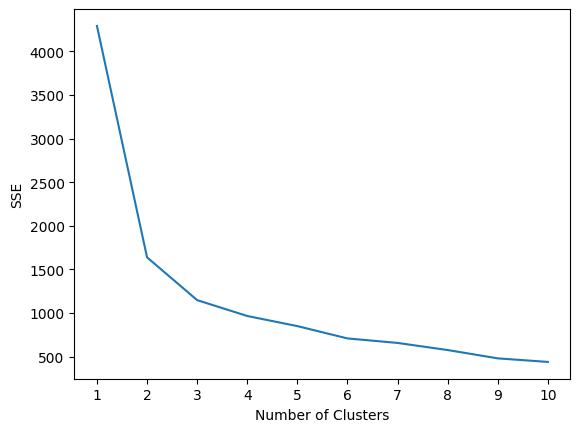

In [10]:
df_cluster = df[['scaled_length', 'scaled_width', 'scaled_draught']]

kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(df_cluster)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


Since the chart *bend* is at 3, we are going to use that as the number of clusters. The resulting cluster number is added back to the original dataframe

In [11]:
kmeans = KMeans(init="random", n_clusters=3, n_init=10, random_state=1)
kmeans.fit(df_cluster)
df['cluster'] = kmeans.labels_
df.loc[df['cluster'] == 0, 'cluster_label'] = 'large'
df.loc[df['cluster'] == 1, 'cluster_label'] = 'medium'
df.loc[df['cluster'] == 2, 'cluster_label'] = 'small'

Lets create 3 more dataframes for each day of data

In [12]:
df_one = df[df['day_of_week'] == 1]
df_two = df[df['day_of_week'] == 2]
df_three = df[df['day_of_week'] == 3]

Lets plot each day of data with coloring by cluster

<Axes: xlabel='lon_deg', ylabel='lat_deg'>

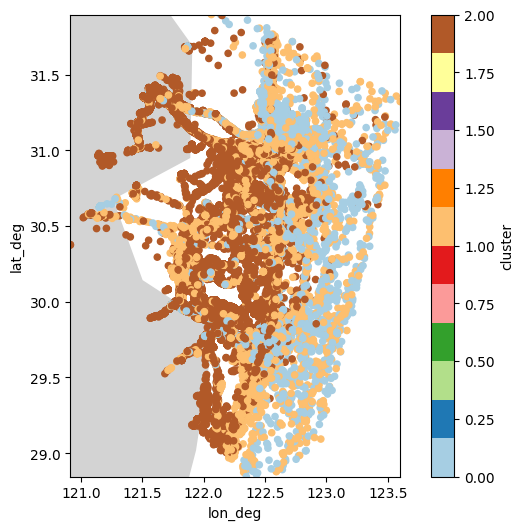

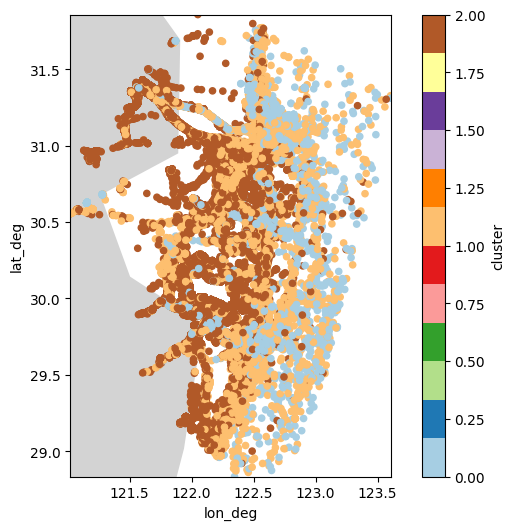

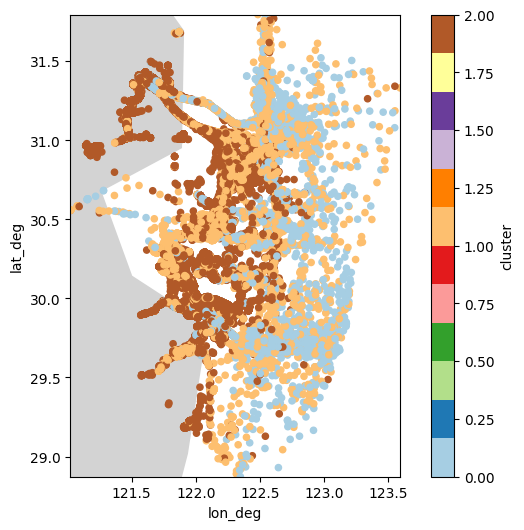

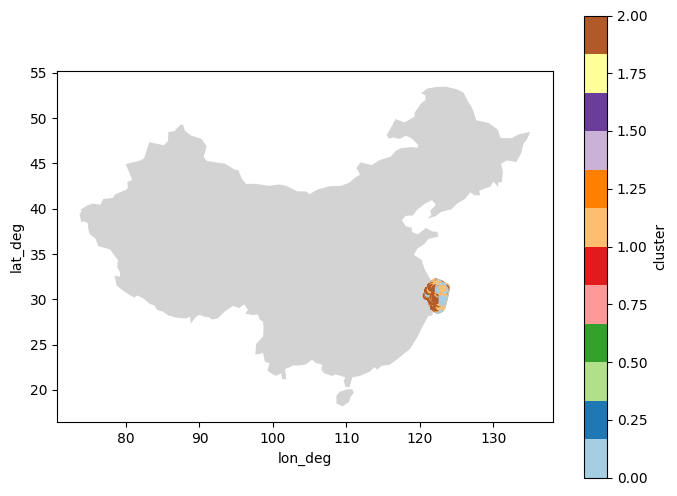

In [22]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax1 = plt.subplots(figsize=(8,6))
fig, ax2 = plt.subplots(figsize=(8,6))
fig, ax3 = plt.subplots(figsize=(8,6))
fig, ax4 = plt.subplots(figsize=(8,6))
china = countries[countries['name'] == 'China']

china.plot(color='lightgrey', ax=ax1)
china.plot(color='lightgrey', ax=ax2)
china.plot(color='lightgrey', ax=ax3)
china.plot(color='lightgrey', ax=ax4)

ax1.set_xlim(df_one['lon_deg'].min(), df_one['lon_deg'].max())
ax1.set_ylim(df_one['lat_deg'].min(), df_one['lat_deg'].max())
df_one.plot(x='lon_deg', y='lat_deg', kind='scatter', c='cluster', colormap='Paired', ax=ax1)

ax2.set_xlim(df_two['lon_deg'].min(), df_two['lon_deg'].max())
ax2.set_ylim(df_two['lat_deg'].min(), df_two['lat_deg'].max())
df_two.plot(x='lon_deg', y='lat_deg', kind='scatter', c='cluster', colormap='Paired', ax=ax2)

ax3.set_xlim(df_three['lon_deg'].min(), df_three['lon_deg'].max())
ax3.set_ylim(df_three['lat_deg'].min(), df_three['lat_deg'].max())
df_three.plot(x='lon_deg', y='lat_deg', kind='scatter', c='cluster', colormap='Paired', ax=ax3)

df_one.plot(x='lon_deg', y='lat_deg', kind='scatter', c='cluster', colormap='Paired', ax=ax4)

34.85829532146454
33.97516906261444
31.16653859615326


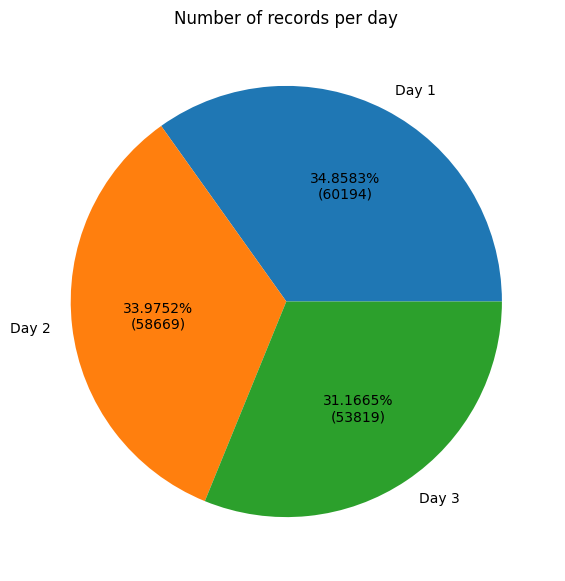

In [14]:
def my_fmt(x):
    print(x)
    return '{:.4f}%\n({:.0f})'.format(x, total*x/100)

total = df.shape[0]

pie_labels = ['Day 1', 'Day 2', 'Day 3']
pie_data = [df_one.shape[0], df_two.shape[0], df_three.shape[0]]
fig = plt.figure(figsize =(10, 7))
plt.title('Number of records per day')
plt.pie(pie_data, labels = pie_labels, autopct=my_fmt)

plt.show()

10.578404366970062
22.96243906021118
66.45915508270264


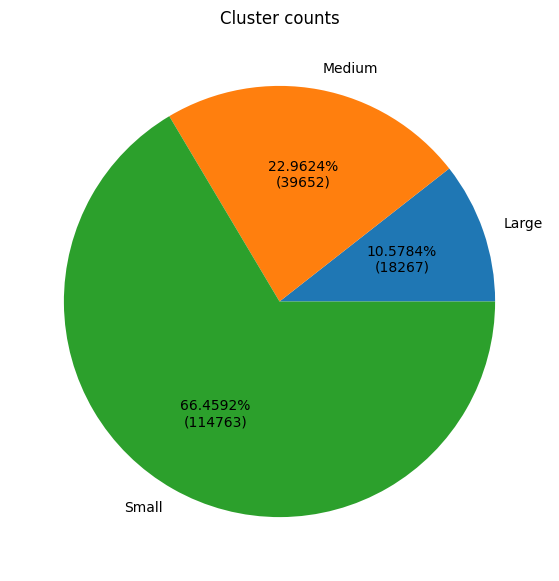

In [15]:

cluster_lg = sum(df['cluster_label'] == 'large')
cluster_md = sum(df['cluster_label'] == 'medium')
cluster_sm = sum(df['cluster_label'] == 'small')

def my_fmt(x):
    print(x)
    return '{:.4f}%\n({:.0f})'.format(x, total*x/100)

total = df.shape[0]

pie_labels = ['Large', 'Medium', 'Small']
pie_data = [cluster_lg, cluster_md, cluster_sm]
fig = plt.figure(figsize =(10, 7))
plt.title('Cluster counts')
plt.pie(pie_data, labels = pie_labels, autopct=my_fmt)

plt.show()
